<a href="https://colab.research.google.com/github/khanhqn1/finance/blob/main/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Financial Budget 2022 Project**

---
Using my 2022 statement document provided by Bank of America, I will be using linear regression to predict my expected purchasing habits for 2023.



**Table of Contents**
---

---




> **Prefix:** Initial EDA

> **Part 1:** Linear Regression

> **Part 2:** Error Analysis

> **Conclusion** 

**Prefix:** Initial EDA
---

---

Loading the data:

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

stmt_path = 'https://raw.githubusercontent.com/khanhqn1/finance/main/stmt.csv'
stmt_df = pd.read_csv(stmt_path)
stmt_df.head()

,Date,Description,Amount,Running Bal.
0,01/01/2022,Beginning balance as of 01/01/2022,NaN,"1,726.31"
1,01/03/2022,NAYAX VENDING 42 12/30 PURCHASE HUNT VALLEY MD,-5.50,"1,720.81"
2,01/03/2022,SPEEDWAY 4959 12/31 PURCHASE SAN DIEGO CA,-45.60,"1,675.21"
3,01/03/2022,DISCOVER DES:E-PAYMENT ID:1502 INDN:NGUYEN KHA...,-186.78,"1,488.43"
4,01/04/2022,PETSMART # 244 01/04 PURCHASE SAN DIEGO CA,-37.09,"1,451.34"


Turn columns into their correct type representation:

In [167]:
#To convert string representation of money into float we need to get rid of commas, then we can cast to float type
stmt_df["Running Bal."] = stmt_df["Running Bal."].str.replace(',', '')
stmt_df["Running Bal."] = stmt_df["Running Bal."].astype(float)

#Do the same for the "Amount" column
stmt_df["Amount"] = stmt_df["Amount"].str.replace(',', '')
stmt_df["Amount"] = stmt_df["Amount"].astype(float)

Initial data visualization:

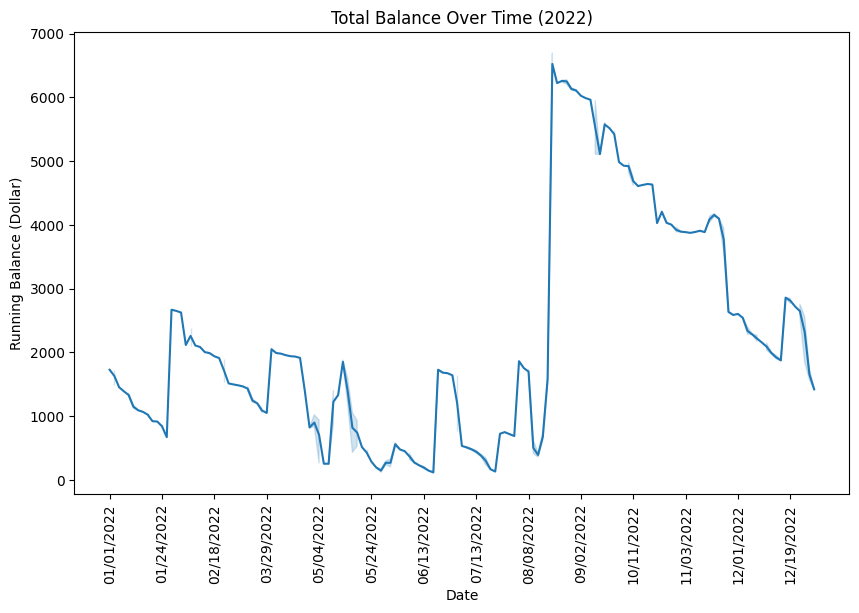

In [168]:
plt.figure(figsize=(10,6))
sns.lineplot(data=stmt_df, x='Date', y='Running Bal.')
plt.xticks(np.arange(0, 154, 11), rotation="vertical")
plt.ylabel("Running Balance (Dollar)")
plt.title("Total Balance Over Time (2022)");

**Part 1:** Linear Regression
---

---

In [169]:
from sklearn.linear_model import LinearRegression

To begin, we first need to find the total amount of spending per month:

In [170]:
#Change the "Date" column to a datetime object and set it as our index
stmt_df["Date"] = pd.to_datetime(stmt_df["Date"])
stmt_df.set_index("Date", inplace=True)

In [171]:
#Now we need to go through every month and add up the "Amount" column to find our total spendings per month
months = ["Jan 2022", "Feb 2022", "Mar 2022", "Apr 2022", "May 2022", "Jun 2022", 
                   "Jul 2022", "Aug 2022", "Sep 2022", "Oct 2022", "Nov 2022", "Dec 2022"]
spendings = []
temp_df = stmt_df[stmt_df["Amount"] <= 0] #We need to make sure that only rows with negative values are being added to calculate total purchases
for month in months:
  spendings.append([np.abs(np.sum(temp_df.loc[month]["Amount"])).round(decimals=2)])
spendings_df = pd.DataFrame(spendings, columns=["Total"])
spendings_df["Month"] = spendings_df.index + 1
spendings_df

,Total,Month
0,1109.50,1
1,1416.97,2
2,525.79,3
3,652.81,4
4,4205.01,5
5,620.44,6
6,1516.80,7
7,2532.20,8
8,1672.12,9
9,1329.26,10


Quick visualization of our new DataFrame of the total spendings per month:

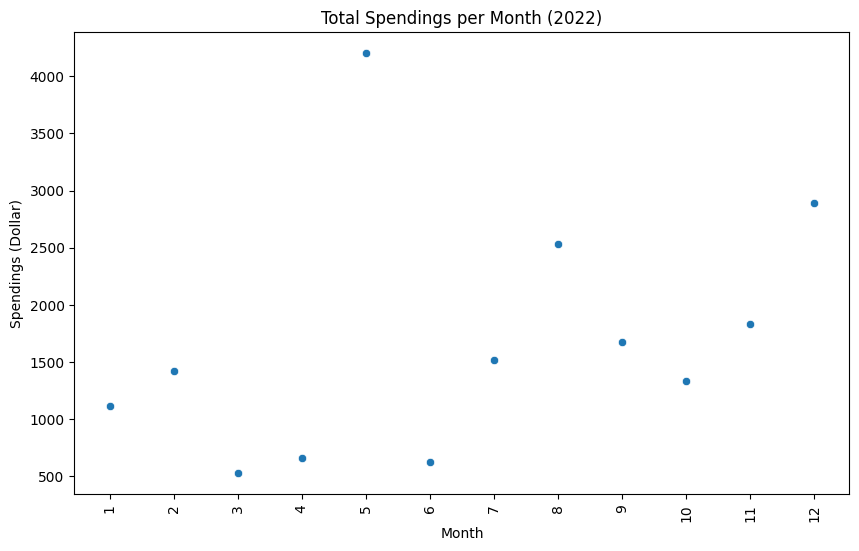

In [172]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=spendings_df, x='Month', y='Total')
plt.xticks(np.arange(1, 13, 1), rotation="vertical")
plt.ylabel("Spendings (Dollar)")
plt.title("Total Spendings per Month (2022)");

We can now set up our linear regression model:

In [173]:
X = spendings_df[["Month"]]
y = spendings_df["Total"]
linreg = LinearRegression().fit(X, y)
pred = linreg.predict(X)

#DataFrame visualization of our predicted spendings for the year 2022
pred_df = pd.DataFrame({'Month': spendings_df["Month"], 'Total': pred.round(decimals=2)})
y_pred = pred_df["Total"]
pred_df

,Month,Total
0,1,1117.00
1,2,1221.47
2,3,1325.93
3,4,1430.40
4,5,1534.86
5,6,1639.33
6,7,1743.79
7,8,1848.26
8,9,1952.72
9,10,2057.19


This is another plot showing the regression line over our actual spendings per month from the year 2022:

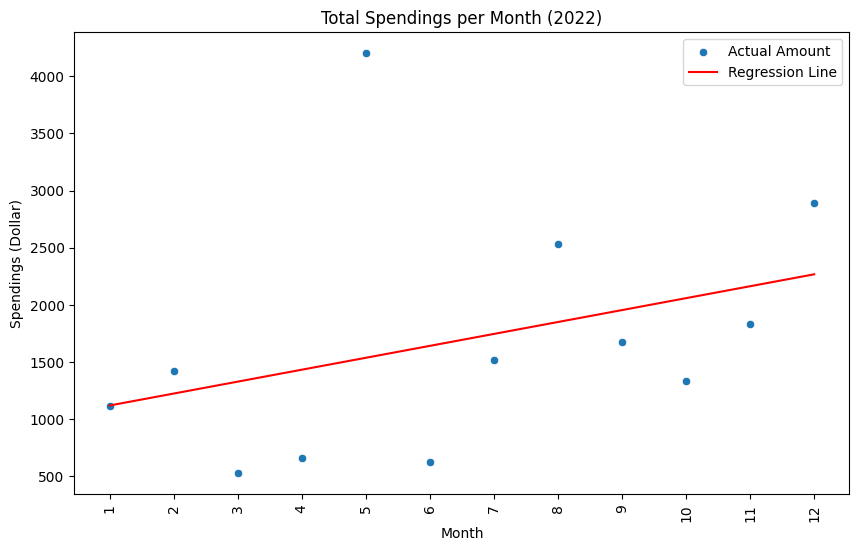

In [174]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=spendings_df, x='Month', y='Total')
plt.xticks(np.arange(1, 13, 1), rotation="vertical")
plt.ylabel("Spendings (Dollar)")
plt.title("Total Spendings per Month (2022)")
plt.plot(X ,pred, color="red")
plt.legend(["Actual Amount", "Regression Line"]);

**Part 2:** Error Analysis
---

---

In [175]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Lastly, we can calulcate the error term between predicted value and actual value using both the mean squared error (MSE) and mean absolute error (MAE) function:

In [176]:
mse_error_term = mean_squared_error(y, y_pred)
mae_error_term = mean_absolute_error(y, y_pred)
mse_error_term, mae_error_term

(922909.5870416671, 695.1725000000001)

Based on the insanely high error values, I believe that this has to do with having a small data set with an outlier. 

We can check this by using a boxplot to see all the outliers within the data set:

<Axes: >

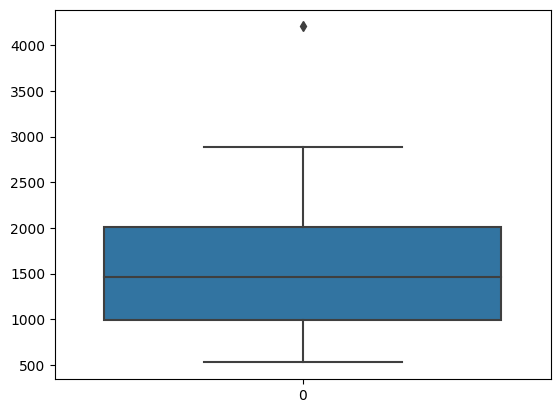

In [177]:
sns.boxplot(spendings_df["Total"])

Although we can never get an ideal number due to the super small data pool, we can reduce this number drastically by replacing the outlier with a more resonable average estimate:

In [178]:
updated_spendings_df = spendings_df
outlier_index = updated_spendings_df[spendings_df["Total"] > 3500].index[0]
updated_spendings_df.at[outlier_index, "Total"] = np.mean(spendings_df[spendings_df["Total"] < 3500]["Total"])

Then, we can redo our linear regression model on our updated Data Frame:

In [179]:
updated_X = updated_spendings_df[["Month"]]
updated_y = updated_spendings_df["Total"]
updated_linreg = LinearRegression().fit(updated_X, updated_y)
updated_pred = updated_linreg.predict(X)

#DataFrame visualization of our predicted spendings for the year 2022
updated_pred_df = pd.DataFrame({'Month': updated_spendings_df["Month"], 'Total': updated_pred.round(decimals=2)})
updated_y_pred = updated_pred_df["Total"]
updated_pred_df

,Month,Total
0,1,730.32
1,2,863.54
2,3,996.77
3,4,1130.00
4,5,1263.22
5,6,1396.45
6,7,1529.68
7,8,1662.90
8,9,1796.13
9,10,1929.36


Scatter Plot of the new updated values:

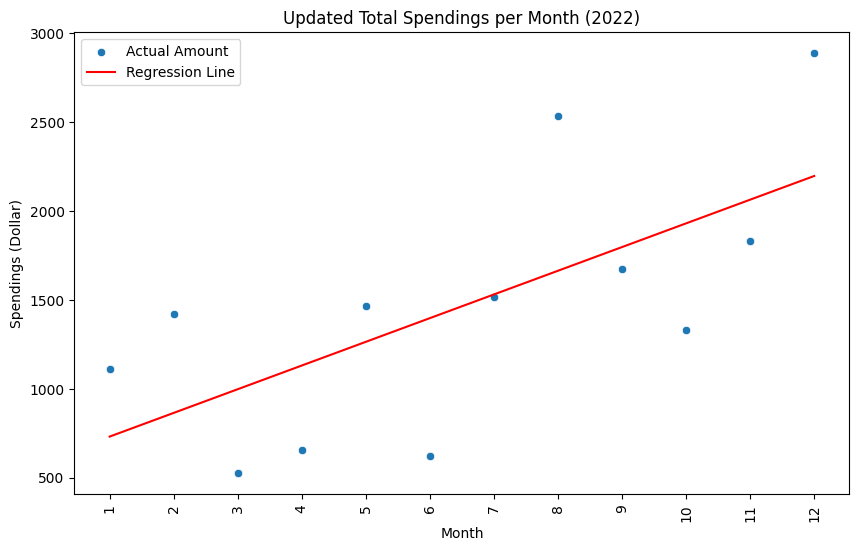

In [180]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=updated_spendings_df, x='Month', y='Total')
plt.xticks(np.arange(1, 13, 1), rotation="vertical")
plt.ylabel("Spendings (Dollar)")
plt.title("Updated Total Spendings per Month (2022)")
plt.plot(X ,updated_pred, color="red")
plt.legend(["Actual Amount", "Regression Line"]);

Updated MSE and MAE values:

In [181]:
updated_mse_error_term = mean_squared_error(updated_y, updated_y_pred)
updated_mae_error_term = mean_absolute_error(updated_y, updated_y_pred)
updated_mse_error_term, updated_mae_error_term

(267130.48823292006, 448.9169696969697)

**Conclusion**
---

---

Based on the results found above, there is an upwards trend with my spending habits and it seems like I am predicted to keep spending more per month in the year 2023. There seems to be a lot of error variance in the linear regression model due to two main reasons: lack of robust data pool resulting in higher likelihood of outliers. In the future, I would not take the average of spendings per month and instead use every individual data set in the "Amount" column of the original Data Frame, excluding the positive values, to make my linear regression model. This would give me a bigger data set allowing me to reduce the MSE/MAE of my model even more drastically. 